# Libraries

In [1]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re, string, unicodedata
import contractions
import nltk
import pickle
import inflect
from bs4 import BeautifulSoup
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Loading data

In [3]:
# load doc into memory
def load_doc(filename):
	file = open(filename, encoding='utf-8')
	text = file.read()
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = []
    highlights =[]
    for name in listdir(directory)[12000:14001]:
        filename = directory + '/' + name
		# load document
        doc = load_doc(filename)
		# split into story and highlights
        story, highlight = split_story(doc)
		# store
        stories.append(story)
        highlights.append(highlight)
    data = pd.DataFrame()
    data["story"] = stories
    data["highlight"] = highlights
    
    return  data

In [4]:
# load stories
directory = r"C:\Users\feder\Desktop\cnn\stories"
data = load_stories(directory)


In [5]:
print('Loaded Stories %d' % len(data))

Loaded Stories 2001


# Cleaning and preprocessing


In [6]:
data.head()

,story,highlight
0,"In a telephone call Monday between Russia's Defense Minister General Sergei Shoigu and the U.S. Secretary of Defence Chuck Hagel, Shoigu described the activity of U.S. and NATO troops near Russia'...","[In cadet school, Russian pupils have questions for NATO, They ask: why do you need to be on our border, Putin used strategic military reasoning to annexe Crimea, Among general public, there's a f..."
1,"The U.N. General Assembly on Thursday approved a resolution calling the Crimean referendum to secede from Ukraine invalid.\n\nThe vote on the nonbinding resolution was 100-11, with 58 countries ab...","[U.N. General Assembly's nonbinding resolution indicates Russia's isolation over Crimea, Ex-Prime Minister Yulia Tymoshenko says she plans to run in Ukraine's May elections, Presidential elections..."
2,"(CNN) -- Former professional baseball pitcher Hideki Irabu was found dead at his California home, the Los Angeles County Sheriff's Department said.\n\nHomicide detectives and representatives from ...","[Irabu helped create the current system used by Japanese players, Irabu was found in his California home Wednesday, Officials determined the cause of death was a suicide, Irabu joined the Major Le..."
3,Twitter is getting into e-commerce. It's now possible to buy goods online in two steps by tweeting a special hashtag.\n\nThe new collaboration between Twitter and American Express will turn the so...,"[Twitter and American Express team up to let cardholders buy products with a hashtag, The discounted goods will require two tweets and then ship to your billing address, American Express already h..."
4,"(CNN) -- Isaac Owusu knows the forests of Kakum National Park in Ghana like the back of his hand.\n\nThe 360-square-kilometer sanctuary is home to hundreds of plant species, as well as endangered ...","[Kakum National Park in Ghana is a 360-square-kilometer sanctuary for hundreds of plant species and animals, Its canopy walkway is a series of bridges stretching 350 meters long, connecting seven ..."


In [7]:
data = data.explode("highlight")

In [8]:
data = data.drop_duplicates(subset="story")

## Normalization

In [9]:
stop_words = set(stopwords.words('english')) 

def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = words.lower()
    return new_words

def remove_punctuation(words):
    """Remove punctuation"""
    new_words = re.sub(r'\([^)]*\)', '', words)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences"""
    new_words = re.sub("[^a-zA-Z]", " ", words) 
    return new_words

def remove_stopwords(words):
    """Remove stop words"""
    new_words = [w for w in words.split() if not w in stop_words]
    long_words=[]
    for i in new_words:
        if len(i)>=1:                  
            long_words.append(i)   

    return (" ".join(long_words)).strip()


def replace_contractions(words):
    """Replace contractions in string of text"""
    return contractions.fix(words)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = replace_contractions(words)
    words = remove_stopwords(words)

    return words

In [10]:
#Call the above function

cleaned_story = []
for t in data['story']:
    cleaned_story.append(normalize(t))

cleaned_highlight = []
for t in data['highlight']:
    cleaned_highlight.append(normalize(t))

data['normalized_text']=cleaned_story
data['normalized_highlight']=cleaned_highlight
data['normalized_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Lemmatization

In [11]:
def lemmatize(words):
    words = lemmatizer.lemmatize(words)
    return words

In [12]:
#Call the above function

lemmatized_story = []
for t in data['normalized_text']:
    lemmatized_story.append(lemmatize(t))
    
lemmatized_highlight = []
for t in data['normalized_highlight']:
    lemmatized_highlight.append(lemmatize(t))

data['cleaned_text']=lemmatized_story
data['cleaned_highlight']=lemmatized_highlight
data['cleaned_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Add start and end tokens for the summarizer

In [13]:
data['cleaned_highlight'] = data['cleaned_highlight'].apply(lambda x : 'starttoken '+ x + ' endtoken')


## Visualize results

In [14]:
data = data[["cleaned_text", "cleaned_highlight"]]
data

,cleaned_text,cleaned_highlight
0,telephone call monday russia defense minister general sergei shoigu secretary defence chuck hagel shoigu described activity nato troops near russia border unprecedented according official russian ...,starttoken cadet school russian pupils questions nato endtoken
1,n general assembly thursday approved resolution calling crimean referendum secede ukraine invalid vote nonbinding resolution countries abstaining latest indication russia isolation within internat...,starttoken n general assembly nonbinding resolution indicates russia isolation crimea endtoken
2,former professional baseball pitcher hideki irabu found dead california home los angeles county sheriff department said homicide detectives representatives los angeles county coroner office determ...,starttoken irabu helped create current system used japanese players endtoken
3,twitter getting e commerce possible buy goods online two steps tweeting special hashtag new collaboration twitter american express turn social media service shopping cart american express members ...,starttoken twitter american express team let cardholders buy products hashtag endtoken
4,isaac owusu knows forests kakum national park ghana like back hand square kilometer sanctuary home hundreds plant species well endangered animals including leopards elephants hornbills african gre...,starttoken kakum national park ghana square kilometer sanctuary hundreds plant species animals endtoken
...,...,...
1996,nasa says latest mars exploring spacecraft track fire thrusters enter orbit sunday night completing month journey million miles nasa maven craft live formal name mars atmosphere volatile evolution...,starttoken ancient mars change dramatically maven sent get answers endtoken
1997,washington sen dianne feinstein called wednesday president obama reverse policy established last year kept suspect christmas day botched jetliner bombing placed fly list failed bombing reminder at...,starttoken sen feinstein failed december airline attack shows must adapt endtoken
1998,garmin sharp teammate saw victory snatched grasp heartbreaking fashion earlier tour de france ramunas navardauskas made sure repeat rain soaked th stage friday navardauskas took courage hands burs...,starttoken ramunas navardauskas wins th stage tour de france endtoken
1999,ferguson missouri police wednesday arrested dozens protesters threatening shut portion interstate near ferguson missouri demonstrators threw rocks police emotionally charged protest aimed persuadi...,starttoken new police arrest people protesting near interstate endtoken


In [15]:
x_test = data['cleaned_text']
y_test = data['cleaned_highlight']

## Tokenization

In [16]:
#!pip install pickle5
import  pickle

In [17]:
def open_test_data_y():
    return open('../tokenizers_vars/y_tokenizer.pickle', 'rb')

with open_test_data_y() as f:
    y_tokenizer = pickle.load(f) 

def open_test_data_x():
    return open('../tokenizers_vars/x_tokenizer.pickle', 'rb')

with open_test_data_x() as f:
    x_tokenizer = pickle.load(f) 

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [19]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 20.37335164184758
Total Coverage of rare words: 0.39457576608869416


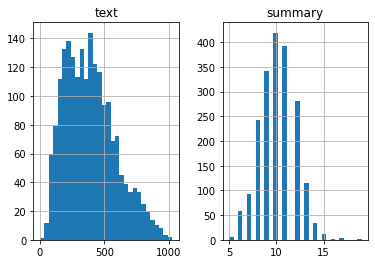

In [20]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlight']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [21]:
cnt=0
for i in data['cleaned_highlight']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_highlight']))

0.9910044977511244


In [22]:
max_text_len=300
max_summary_len=12

In [23]:
#convert text sequences into integer sequences
x_test_seq = x_tokenizer.texts_to_sequences(x_test) 



In [24]:
#padding zero upto maximum length
x_test = pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')



In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.13038910359836
Total Coverage of rare words: 12.006825652323979


In [26]:
#convert text sequences into integer sequences
y_test_seq    =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_test    =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')


In [27]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

# Saving the data

In [28]:
np.save("../final_data/x_test.npy", x_test)
np.save("../final_data/y_test.npy", y_test)
